## Data Challenge for Smartvid.io candidates:
### Cat vs Dog classifier
This notebook walks you through training a simple Cat vs Dog classifier. We would like to you to help us understand the training data, quantify the performance of a neural network model, make improvements, and submit results against an unlabeled test dataset. Along the way are **5 questions** that you should answer. Please email this notebook to glong@smartvid.io when you are finished.

### Rules:
1) Test data cannot be used for training. No hand labeling the test set.

2) Show all of your work. Don't worry about making too many cells.

In [1]:
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image

## Download the dataset

In [54]:
import requests

def download_file_from_google_drive(id, destination, total_size=0):
    """ General method for downloading from Google Drive.
    Doesn't require using API or having credentials
    :param id: Google Drive id for file (constant even if filename changes)
    :param destination: directory where to download the file
    """
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination, total_size)    

def get_confirm_token(response):
    """ Part of keep-alive method for downloading large files from Google Drive
    Discards packets of data that aren't the actual file
    :param response: session-based google query
    :return: either datapacket or discard unneeded data
    """
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination, total_size=0):
    CHUNK_SIZE = 32768

    with notebook.tqdm(desc=destination, total=total_size, unit='B', unit_scale=True) as pbar:
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    pbar.update(CHUNK_SIZE)
                    f.write(chunk)
                
    print('Download Complete')

file_id = '1NbeXE_vX-v7RO1WTOlZgIP0gfRGSD01B'
destination = './dogscats.zip'
download_file_from_google_drive(file_id, destination, total_size=707684086)


Download Complete


## Extract the zip file

In [44]:
import zipfile
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
data_path = Path('./dataset').absolute()
print(data_path)

/Users/garylong/workspace/smartvid-data-challenge/dataset


In [3]:
print(os.listdir(data_path))

['valid', '.DS_Store', 'train', 'test2']


## Load data names and categories into a Pandas dataframe
The following function discovers the filenames and categories for the challenge

In [4]:
from os import fspath
def create_df(datapath : Path) -> pd.DataFrame:
    """
    Function to create a dataframe from a directory of jpgs
    
    Parameters:
    datapath (pathlib Path): path to the top level directory for training or validation
    
    Returns:
    df: Pandas dataframe consisting of 'filename' and 'category' columns
    """ 
    
    filenames = list(datapath.glob('**/*.jpg'))
    categories = []
    for filename in filenames:
        category = filename.stem.split('.')[0]
        categories.append(category)
    #fspath changes pathlib posixpath to str
    df = pd.DataFrame({
        'filename': [fspath(f) for f in filenames],
        'category': categories
    })

    return df

## Create dataframes for training and validation

In [5]:
df_train = create_df(data_path.joinpath('train'))
df_val = create_df(data_path.joinpath('valid'))

## Question 1) Write a function to display the training and validation data with their labels. 
Describe the datasets, the class counts, and anything else of note.

/Users/garylong/workspace/smartvid-data-challenge/dataset/train/dogs/dog.4818.jpg


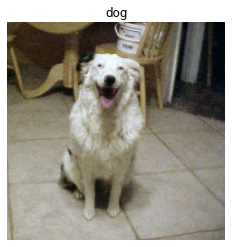

In [19]:
# Here is a little something to help you get started
index=13
img = Image.open(df_train.iloc[index]['filename'])
plt.title(df_train.iloc[index]['category'])
plt.axis('off')
plt.imshow(img);

### Data Sample
Due to the large size of the dataset, sample a portion of the data for model building. The numbers here are a suggestion, feel free to use as much of the provided data as you want. I usually start with a small subset to get functions working correctly rather than wasting a lot of time waiting for code to break.

In [22]:
df_train = df_train.sample(3200)
df_val = df_val.sample(320)

### Pytorch Model
Below is some starter code for you to work with. You will have an opportunity to improve the code later in the notebook if necessary.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models, transforms
import time
import os
import copy

In [24]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        MyRotateTransform([0,-90]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [29]:
class DatasetCatsAndDogs(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform
        self.classes = ['cat','dog']
        self.int2category = {k:v for k,v in enumerate(self.classes)}
        self.category2int = {v:k for k,v in self.int2category.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img =  Image.open(self.df.iloc[index]['filename'])
        if 'category' in self.df.columns:
            label = self.df.iloc[index]['category']
        else:
            label = None
        
        if self.transform is not None:
            img = self.transform(img)
        
        if label is None:
            return img
        else:
            return img, np.array(self.category2int[label])

In [30]:
train_dataset = DatasetCatsAndDogs(df_train, transform=data_transforms['train'])
valid_dataset = DatasetCatsAndDogs(df_val, transform=data_transforms['valid'])

In [31]:
num_workers=0
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=num_workers)

In [32]:
def imshow(inp, title=None, imgsize=3):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(imgsize*2,imgsize*2))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

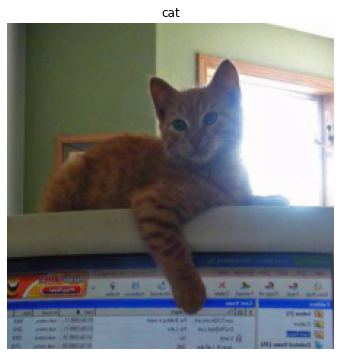

In [34]:
index = int(np.random.randint(0,high=len(df_train),size=1,dtype=int))
img, lab = train_dataset.__getitem__(index)
imshow(img,train_dataset.int2category[int(lab)])

In [35]:
def show_batch(inp, title=None, imgsize=3):
    """show a batch of data with their titles"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    sz = inp.shape[0]
    bs = inp.shape[1]/inp.shape[0]
    rows = int(bs**0.5)
    cols = int(bs/rows)
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
    for i, ax in enumerate(axs.flatten()):
        img = Image.fromarray(np.uint8(inp[:,(i*sz):(i+1)*sz,:]*255.0))
        ax.imshow(img)
        if title is not None:
            ax.set_title(title[i])
        ax.axis('off')
    plt.tight_layout()
    return fig, axs

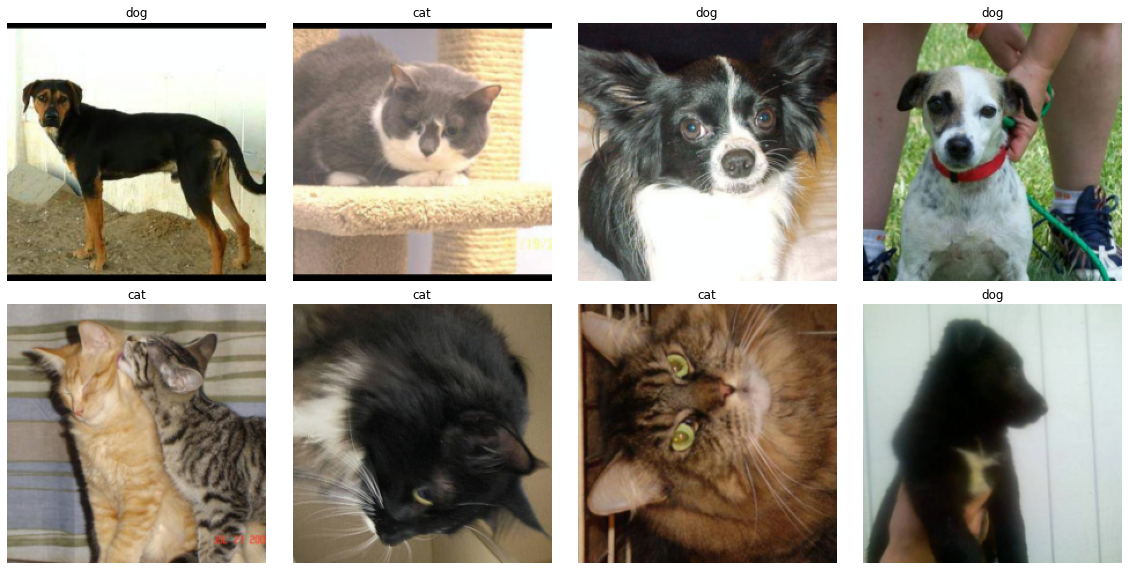

In [36]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs,padding=0)
show_batch(sample_train_images, title=[train_dataset.int2category[int(v)] for v in classes.numpy()]);

In [37]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')

Train dataset size: 3200
Validation dataset size: 320


In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(iter(dataloaders[phase]), total=int(len(dataloaders[phase])))
            counter = 0
            # Iterate over data.
            for bi, d in enumerate(tk0):
            #for inputs, labels in iter(dataloaders[phase]):
                inputs, labels = d
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * dataloaders[phase].batch_size)),
                                acc = float(running_corrects.double() / (counter * dataloaders[phase].batch_size)) )
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) * dataloaders[phase].batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [40]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Freeze the model
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default    
model_ft.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [41]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [44]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------



train Loss: 0.6944 Acc: 0.6603



val Loss: 0.7102 Acc: 0.6719

Epoch 1/3
----------



train Loss: 0.6534 Acc: 0.6978



val Loss: 0.5984 Acc: 0.7406

Epoch 2/3
----------



train Loss: 0.5768 Acc: 0.7266



val Loss: 0.5581 Acc: 0.7656

Epoch 3/3
----------



train Loss: 0.5696 Acc: 0.7219



val Loss: 0.5481 Acc: 0.7656

Training complete in 16m 35s
Best val Acc: 0.765625


## Question 2) Training metrics
1) Modify the training code to log some metrics after each epoch. 

2) Plot Accuracy and Loss against the training and validation data.  

## Your Answer:

## Question 3) Loss Functions
The model takes an image and predicts a categorical output, a dog or cat. What loss function should be used if the model has a single output?

## Your Answer:

## Question 4) Model Predictions
Briefly discuss the advantages / disadvantages of making model that predicts Dog, Cat, or Other vs a simple Dog or Cat classifier.

## Your Answer:

## Question 5) Improvements 
Describe the training job, how it is working vs your expectations. Describe what steps, if any, should be taken to make the model perform better.  If you have time, try to sort any issues that you've identified and train a new model.  Part of making a good model is visualizing the results. Write some visualization code to inspect where the model is working and where it is not.  Write your own functions in the notebook to inspect / correct the training data, if necessary. Show your work and when you are happy with your model, evaluate it against the test set and submit the CSV.

## Your Answer:

## Model Evalution / Submission
Run your model against the test set and prepare the output for submission

## Prepare test dataframe

In [47]:
test_filenames = os.listdir(data_path.joinpath('test2'))
df_test = pd.DataFrame({
    'filename': test_filenames
})
df_test['filename'] = df_test['filename'].apply(lambda x: Path(data_path).joinpath('test2',x))
nb_samples = df_test.shape[0]
print(f'Created test set with {nb_samples} samples')

Created test set with 5000 samples


In [48]:
test_dataset = DatasetCatsAndDogs(df_test, transform=data_transforms['valid'])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

Replace the base_model variable with your model

In [49]:
def get_predictions(model, data_loader, classes):
    was_training = model.training
    model.eval()
    
    pout = {}
    
    tk0 = tqdm(iter(data_loader), total=int(len(data_loader)))
    
    batch = 0
    for i, inputs in enumerate(tk0):
        
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        pout = {**pout, **{batch+iv:classes[int(v)] for iv, v in enumerate(preds.numpy())}}
        batch += min((len(preds),data_loader.batch_size))
                
    model.train(mode=was_training)
    
    return pout

In [50]:
predictions = get_predictions(model_ft, test_loader, test_dataset.classes)

In [51]:
df_test['prediction'] = pd.DataFrame(data={'prediction':predictions})

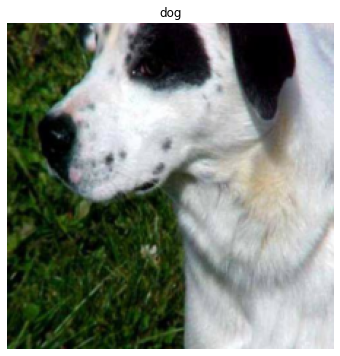

In [52]:
index=10
img = test_dataset.__getitem__(index)
imshow(img,df_test.iloc[index]['prediction'])

## Submission
Run the next block of code and mail the csv file to glong@smartvid.io

In [53]:
df_submission = df_test.copy()
df_submission['id'] = df_submission['filename'].apply(lambda x: Path(x).stem)
df_submission['label'] = df_submission['prediction']
df_submission.drop(['filename', 'prediction'], axis=1, inplace=True)
df_submission.to_csv('submission.csv', index=False)